### Abstract

I propose that this validation step consists of adding realistic gains (using hera_sim) to the simulation (eGSM + GLEAM + noise). I will use the tools available in hera_sim.sigchain to introduce gains (phase offsets, delay, bandpass) to the simulated visibilities. The resulting visibilities will be pushed through Redcal (redcal + omnical).  

CASA requires that I provide it with a model to calibrate the visibilities to in the form of either a componentlist or a CASA .image file. Nick has a gleam FITS file that is fed into a model making script that makes an image cube. Because this model is only of GLEAM and not eGSM + GLEAM + noise this could affect things. The other option is to calibrate the simulation with gains added to the same simulation but with no gains added. These are the true visibilities.  

Finally, I will compare the calibrated visibilities from Redcal to the ones from CASA.

In [242]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
#https://python-future.org/quickstart.html

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt, numpy as np
import matplotlib.colors as mcolors
import hera_cal, hera_qm, hera_sim
import linsolve
import scipy
import os
import platform

from matplotlib import gridspec
from pyuvdata import UVData
from datetime import datetime
from IPython.display import Markdown
from hera_cal import io, redcal, abscal, utils, apply_cal
from hera_cal.datacontainer import DataContainer
from copy import deepcopy
from hera_cal.utils import split_pol, split_bl
from importlib import import_module

In [2]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2019-10-12 18:27:08.763915


 - Major Step Description: Validation of the link between the externally calibrated visibilities from CASA and the Omnical calibrated visibilities.
 - Minor Variation Description: 
 - Pipelines Tested: `hera_cal`
 - Criteria:
    1. 
        1. 
        2. 


### Summary

1. RIMEz Simulation
    - GLEAM (point sources)  
    - eGSM (diffuse sources)  
    - ATeam (bright sources not found in GLEAM)  
    - Built with only sources that have known spectrum  
    - 1024 channels, 100-200 MHz  
    - LST range of around 20h55m57.8s~12h32m40.7s  
    - Noise (simulation has no noise but I will add it)  
    
    
2. Adding realistic gains to simulation.
    1. Using `hera_sim.sigchain` to add gains to the simulation.
    2. Types of gains: phase offsets, delay, bandpass
    
    
3. CASA Calibration
    1. Calibrate the RIMEz data with added artifacts using Nick Kern's CASA pipeline.
    2. Save calibrated visibilities.  
    3. Convert npz solutions to a calfits file.  
    4. Apply CASA solutions to uncalibrated data file.  
    
    
4. Redcal and Omnical Calibration
    1. Follow the first part of Josh Dillon's 2.0.0 Validation Step:
        https://nbviewer.jupyter.org/github/HERA-Team/hera-validation/blob/test-2.1.0/test-series/2/test-2.0.0.ipynb
    2. Save `redcal` and `omnical` visibilities.  
    

5. Run Abscal


6. Calibrated Visibility Comparison

In this notebook I will calibrate to simulated data from RIMEz:

PATH: **/lustre/aoc/projects/hera/zmartino/hera_calib_model/IDR2/abscal_files/**  
FILE: **zen.2458106.27878.uvh5**  --> **zen.2458106.27878.xx.HH.uv**  
LST: **1h 57m 25.8183s**

### Software

In [3]:
print("Python Version:\n \t",platform.sys.version)

for module in ["pyuvdata", "hera_stats", "hera_sim", "hera_qm", "hera_pspec",
               "linsolve", "uvtools", "numpy", "healvis", "healpy"]:
    try:
        _mdl = import_module(module)
    except ModuleNotFoundError:
        pass
    
    if hasattr(_mdl, 'version'):
        gh = getattr(_mdl.version, 'git_hash', None)
    print("Module {:<11}....\tVersion {:<7}.......\tGit {}".format(module, _mdl.__version__, gh))

Python Version:
 	 3.7.1 | packaged by conda-forge | (default, Feb 25 2019, 21:02:05) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Module pyuvdata   ....	Version 1.4.1  .......	Git 93cc9ca6024c10b36d16b7351b6f415d19cf5044
Module hera_stats ....	Version 1.4.1  .......	Git 93cc9ca6024c10b36d16b7351b6f415d19cf5044
Module hera_sim   ....	Version 0.0.1  .......	Git b"b'101444f408b7524dc774ad7ce7c12c77acf6cd45'"
Module hera_qm    ....	Version 1.0    .......	Git 400ee8f93321fb27078533083a2cc46ee56254f9
Module hera_pspec ....	Version 1.0    .......	Git 400ee8f93321fb27078533083a2cc46ee56254f9
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git 92faf0f37a4e33c217b9331d27b3a3397ff95e3e
Module numpy      ....	Version 1.15.0 .......	Git None
Module healvis    ....	Version 1.15.0 .......	Git None
Module healpy     ....	Version 1.12.9 .......	Git None


### Data

The following paths reflect the exact locations of all data used in this test:  
**/lustre/aoc/projects/hera/zmartino/hera_calib_model/IDR2/abscal_files/zen.2458106.27878.uvh5**

In [9]:
path = '/Users/tashaleebillings/Desktop/data/2.2Validation/'
rimez_sim = 'zen.2458106.27878.uvh5'

# RIMEz Simulation

Use pyuvdata to take a quick look at simulated data.

# Adding Realistic Gains 

### Generate Uncalibrated Data

In [11]:
%%time
hd = io.HERAData(path+rimez_sim)
data, flags, nsamples = hd.read()

Telescope mock-HERA is not in known_telescopes.
Telescope mock-HERA is not in known_telescopes.


CPU times: user 18.9 s, sys: 13.7 s, total: 32.6 s
Wall time: 38.8 s


In [7]:
print(hd.history.replace("\n","").replace(". ","\n"))

time series generated from /users/zmartino/zmartino/hera_calib_model/IDR2/hera52_100-200MHz_HERA_dipole_egsm.rimezh5 and /users/zmartino/zmartino/hera_calib_model/IDR2/hera52_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01.rimezh5  Read/written with pyuvdata version: 1.4.0
 Git origin: https://github.com/RadioAstronomySoftwareGroup/pyuvdata.git
 Git hash: d1829efacb60da384f64a8f25a280441bfa9d68a
 Git branch: master
 Git description: v1.3-663-gd1829ef
 Downselected to specific polarizations using pyuvdata
 Downselected to specific times using pyuvdata
Combineddata along polarization axis using pyuvdata
 Read/written with pyuvdata version: 1.4.1
 Git origin: https://github.com/RadioAstronomySoftwareGroup/pyuvdata.git
 Git hash: 3781f1034f83cac4471433f8a7c0c8acfa1d7036
 Git branch: casa_byte_handling
 Git description: v1.4-277-g3781f10
 Downselected to specific antennas using pyuvdata
 Read/written with pyuvdata version: 1.4.1
 Git origin: https://github.com/RadioAstronomySoftwareGroup

In [8]:
%%time
np.random.seed(21)
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())

# generate gains with a realistic bandpass and delays between -20 and 20 ns
true_gains = hera_sim.sigchain.gen_gains(hd.freqs/1e9, ants, dly_rng=(-20, 20))

# add random phase offsets to each antenna's gain
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in true_gains.keys()}

# uncalibratate data and save
true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
              for ant, g in true_gains.items()}
apply_cal.calibrate_in_place(data, true_gains, gain_convention='multiply')
hd.update(data=data)
hd.write_uvh5(path+'uncalibrated_' + rimez_sim, clobber=True)

CPU times: user 46 ms, sys: 7.76 ms, total: 53.8 ms
Wall time: 57.2 ms


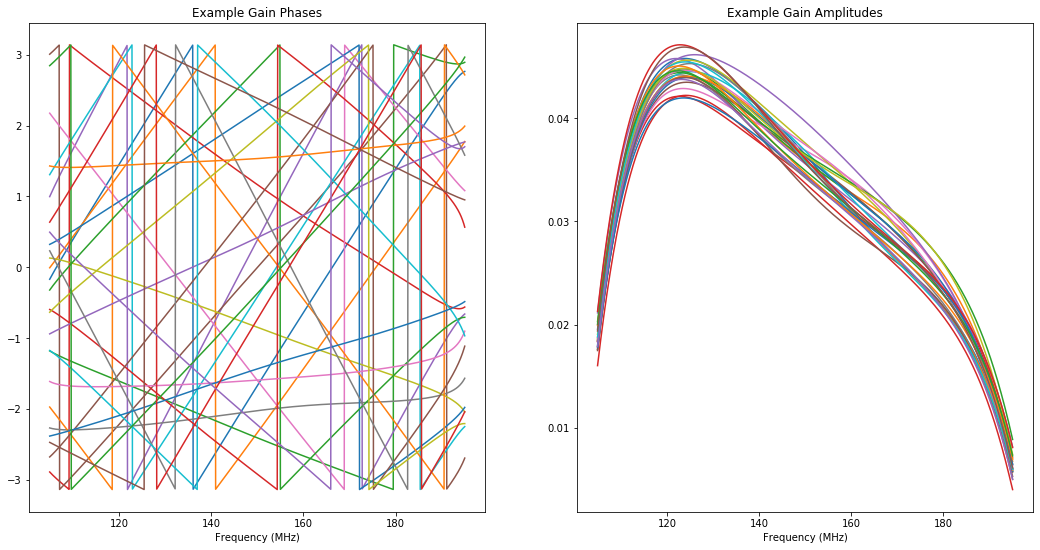

In [9]:
fig, ax = plt.subplots(1,2, figsize=(18,9))
for ant in ants[::4]:
    ax[0].plot(hd.freqs[50:-50]/1e6, np.angle(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[0].set_title('Example Gain Phases')
    ax[0].set_xlabel('Frequency (MHz)')
    ax[1].plot(hd.freqs[50:-50]/1e6, np.abs(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[1].set_title('Example Gain Amplitudes')
    ax[1].set_xlabel('Frequency (MHz)')

# CASA Calibration

In [11]:
# Need to split the visibilities up into xx and yy pol

uvd = UVData()
uvd.read(path+'uncalibrated_' + rimez_sim)
#uvd.rdate =''
uvd.select(polarizations=[-5])
uvd.write_uvh5(path+"zen.2458106.27878.xx.HH.uvh5")
#uvd.write_uvfits("/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.xx.HH.uvfits",
#                 spoof_nonessential=True,force_phase=True)
del(uvd)

uvd = UVData()
uvd.read(path+'uncalibrated_' + rimez_sim)
#uvd.rdate =''
uvd.select(polarizations=[-6])
uvd.write_uvh5(path+"zen.2458106.27878.yy.HH.uvh5")

Telescope mock-HERA is not in known_telescopes.
Telescope mock-HERA is not in known_telescopes.


Path to YAML parameter file: **/Users/tashaleebillings/Desktop/Research/plimpy/scripts/2.2Validation/2.2skycal_params.yml**

Path to Pipeline Script: **/Users/tashaleebillings/Desktop/Research/plimpy/scripts/2.2Validation/2.2skycal_pipe.py**

### Calibrate RIMEz using CASA

In [5]:
%%bash

more /Users/tashaleebillings/Desktop/Research/plimpy/scripts/2.2Validation/2.2skycal_params.yml

# Validation 2.2: 2.2skycal_params.yml
#
# parameter file for 2.2skycal_pipe.py
#
# Notes:
#   All output filenames have an out_dir root (ex. logfile).
#   All input filenames have a work_dir root (ex. gen_model.cl_params.gleamfile)
#   except for data_file which has a data_root root.

#---------------------------------------------------------------
# IO Parameters
#---------------------------------------------------------------
io :
  work_dir : './'         # directory to work in
  out_dir : '/Users/tashaleebillings/Desktop/data/2.2Validation/'  # directory to dump all output in
  logfile : '/Users/tashaleebillings/Desktop/data/2.2Validation/2.2skycal_out.log'  # log file   
  errfile : '/Users/tashaleebillings/Desktop/data/2.2Validation/2.2skycal_err.log' # error file
  joinlog : True       # redirect error output into logfile
  overwrite : True     # overwrite
  verbose : True        # report feedback to standard output

  # path to CASA executable or CASA command
  casa : 'casa'



In [6]:
%%bash

time
python /Users/tashaleebillings/Desktop/Research/plimpy/scripts/2.2Validation/2.2skycal_pipe.py -c /Users/tashaleebillings/Desktop/Research/plimpy/scripts/2.2Validation/2.2skycal_params.yml
time


==>  
The start-up time of CASA may vary
depending on whether the shared libraries
are cached or not.

]0;IPython: plimpy/notebooksIPython 5.4.0 -- An enhanced Interactive Python.

CASA 5.4.1-32   -- Common Astronomy Software Applications

Found an existing telemetry logfile: /Users/tashaleebillings/.casa/casastats-541-32-3f03c950526a380119-20191011-015215.log
Telemetry initialized. Telemetry will send anonymized usage statistics to NRAO.
You can disable telemetry by setting environment variable with
export CASA_ENABLE_TELEMETRY=false
or by adding the following line in your ~/.casarc file:
EnableTelemetry: False
==>  
The start-up time of CASA may vary
depending on whether the shared libraries
are cached or not.

]0;IPython: plimpy/notebooksIPython 5.4.0 -- An enhanced Interactive Python.

CASA 5.4.1-32   -- Common Astronomy Software Applications

Found an existing telemetry logfile: /Users/tashaleebillings/.casa/casastats-541-32-3f03c950526a380119-20191011-015215.log
Telemetry ini


real	0m0.000s
user	0m0.000s
sys	0m0.000s
--> CrashReporter initialized.
2019-10-12 22:28:27	WARN	MSFitsInput::fillAntennaTable	mock-HERA there is at least one gap in the antenna sequence found in the FITS AN table. Empty rows will be inserted into the ANTENNA table representing the gaps.
2019-10-12 22:28:27	WARN	MSFitsInput::fillExtraTable	No systemic velocity for field 0
2019-10-12 22:28:27	WARN	MSFitsInput::fillExtraTable	No rest frequency for field 0
--> CrashReporter initialized.
2019-10-12 22:32:04	WARN	componentlist::close	componentlist closed
--> CrashReporter initialized.
2019-10-12 22:33:28	WARN	importfits::::	This image has no beam or angular resolution provided, so you will not receive warnings from
2019-10-12 22:33:28	WARN	importfits::::+	tasks such as imregrid if your image pixels do not sample the the angular resolution well.
2019-10-12 22:33:28	WARN	importfits::::+	(This only affects warnings, not any functionality).
2019-10-12 22:33:28	WARN	importfits::::+	Providing a 

In [12]:
#-------------------------------------------------------------------------------
# Direction Independent Calibration
#-------------------------------------------------------------------------------
if params['di_cal']:
    # start block
    time = datetime.utcnow()
    utils.log("\n{}\n...Starting DI_CAL: {}\n".format("-"*60, time), f=lf, verbose=verbose)
    cal_kwargs = dict(list(algs['gen_cal'].items()) + list(global_vars(varlist).items())+list(cf['obs'].items()) + list(algs['di_cal'].items()))
    #utils.log(json.dumps(cal_kwargs, indent=1) + '\n', f=lf, verbose=verbose)

    # Perform Calibration
    kwargs = global_vars(varlist)
    kwargs.update(cal_kwargs)
    gaintables = calibrate(**kwargs)

    # end block
    time2 = datetime.utcnow()
    utils.log("...finished DI_CAL: {:d} sec elapsed".format(utils.get_elapsed_time(time, time2)), f=lf, verbose=verbose)

### Save calibrated visibilities.

In [72]:
# Read in the CASA calibrated MS file (only the corrected data) and convert to a uvh5 file.

ms = "/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.ms"
uvd_ms = UVData()
uvd_ms.read_ms(filepath=ms, data_column="CORRECTED_DATA")

uvd_ms.write_uvh5(ms[:-2]+"uvh5") 

### Convert npz solutions to a calfits file

In [57]:
import matplotlib
import matplotlib.pyplot as plt
from pyuvdata import UVCal, UVData
import pyuvdata.utils as uvutils
import numpy as np
import argparse
import os
import scipy.signal as signal
from sklearn import gaussian_process as gp
import copy
import hera_cal as hc
import copy


# Required Parameters
fname= path+"zen.2458106.28114.HH.uv.ms.abs.calfits"
uv_file="/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.xx.HH.uvh5"
uv_pols='*'
# Delay Solution Parameters
dly_files=[path+"zen.2458106.28114.HH.uv.ms.K.cal.npz"]
phs_files=[path+"zen.2458106.28114.HH.uv.ms.Gphs.cal.npz"]
amp_files=[path+"zen.2458106.28114.HH.uv.ms.Gamp.cal.npz"]
bp_files=[path+"2.2Validation/zen.2458106.28114.HH.uv.ms.B.cal.npz"]

out_dir=None
TTonly=True
plot_dlys=False
plot_phs=False
plot_amp=False
plot_bp=False
noBPphase=False
noBPamp=False
bp_TTonly=False
bp_medfilt=False
medfilt_kernel=13
bp_amp_antavg=False
bp_flag_frac=0.3
bp_broad_flags=False
medfilt_flag=False
bp_gp_smooth=False
bp_gp_max_dly=200.0
bp_gp_nrestart=1
bp_gp_thin=4
gain_amp_antavg=False
verbose=True
multiply_gains=True
bp_gp_optimizer=None
medfilt_flag_cut=10
taper_flagged_edges=False
uv_pols=None
gain_convention='multiply'
overwrite=True


def echo(message, type=0, verbose=True):
    if verbose:
        if type == 0:
            print(message)
        elif type == 1:
            print('\n{}\n{}'.format(message, '-'*40))

"""
Convert *.npz output from sky_image.py into single or multi-pol calfits file.
Currently only supports data and gain solutions with a single spectral window.
"""
# get out_dir
if out_dir is None:
    out_dir = "./"

# load UVData
echo("...loading uv_file", verbose=verbose)
uvd = UVData()
uvd.read(uv_file, polarizations=uv_pols)

# get ants and antpos
antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=True)
ants = list(ants)

# get freqs, times, jones
freqs = np.unique(uvd.freq_array)
times = np.unique(uvd.time_array)
Nfreqs = len(freqs)
Nants = len(ants)
pols = uvd.polarization_array
jones = np.array([uvutils.jnum2str(p) for p in pols])
Njones = len(jones)

# construct blank gains and flags
gains = np.ones((Nants, Nfreqs, 1, Njones), dtype=np.complex)
flags = np.zeros((Nants, Nfreqs, 1, Njones), dtype=np.bool)
flagged_ants = np.zeros(Nants, dtype=np.bool)

# process delays if available
if dly_files:
    echo("...processing delays", verbose=verbose, type=1)
    delays = np.zeros((Nants, Njones), dtype=np.float)
    delay_flags = np.zeros((Nants, Njones), dtype=np.bool)
    for dly_file in dly_files:
        echo("...processing {}".format(dly_file), verbose=verbose)
        # get CASA delays and antennas
        dly_data = np.load(dly_file)
        dly_ants = dly_data['delay_ants']
        dlys = dly_data['delays'][:Njones, 0, :]
        dly_flags = dly_data['delay_flags'][:Njones, 0, :]
        dly_ants = dly_ants.tolist()
        dlys *= 1e-9
        # reorder antennas to be consistant w/ ants array
        dlys = np.array([dlys[:, dly_ants.index(a)] if a in dly_ants else 0.0 for a in ants])
        dly_flags = np.array([dly_flags[:, dly_ants.index(a)] if a in dly_ants else True for a in ants])
        # keep only limited information
        if TTonly:
            echo("...keeping only TT component of delays", verbose=verbose)
            A = np.vstack([antpos[:, 0], antpos[:, 1]]).T
            fit = np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(dlys)
            dlys = A.dot(fit)
        # add to delay array
        delays += dlys
        delay_flags += dly_flags
        flagged_ants += np.min(dly_flags, axis=1)  # only a flagged ant if all pols are flagged

    # turn into complex gains
    dly_gains = np.exp(2j*np.pi*(freqs-freqs.min())[None, :, None, None] * delays[:, None, None, :])
    dly_gain_flags = delay_flags[:, None, None]

    # multiply into gains
    gains *= dly_gains

    # add into flags
    flags += dly_gain_flags

# process overall phase if available
if phs_files:
    echo("...processing gain phase", verbose=verbose, type=1)
    phases = np.zeros((Nants, Njones), dtype=np.float)
    phase_flags = np.zeros((Nants, Njones), dtype=np.bool)
    for phs_file in phs_files:
        echo("...processing {}".format(phs_file), verbose=verbose)
        # get phase antennas and phases
        phs_data = np.load(phs_file)
        phs_ants = phs_data['phase_ants']
        phs = phs_data['phases'][:Njones, 0, :]
        phs_flags = phs_data['phase_flags'][:Njones, 0, :]
        phs_ants = phs_ants.tolist()
        # reorder to match ants
        phs = np.array([phs[:, phs_ants.index(a)] if a in phs_ants else 0.0 for a in ants])
        phs_flags = np.array([phs_flags[:, phs_ants.index(a)] if a in phs_ants else True for a in ants])
        # add to phases
        phases += phs
        phase_flags += phs_flags
        flagged_ants += np.min(phs_flags, axis=1)

    # construct gains
    phase_gains = np.exp(1j * phases)

    # mult into gains
    gains *= phase_gains[:, None, None]

    # add into flags
    flags += phase_flags[:, None, None]

# process overall amplitude if available
if amp_files:
    echo("...processing gain amp", verbose=verbose, type=1)
    amplitudes = np.ones((Nants, Njones), dtype=np.float)
    amplitude_flags = np.zeros((Nants, Njones), dtype=np.bool)
    for amp_file in amp_files:
        echo("...processing {}".format(amp_file), verbose=verbose)
        # get amp antenna and amps
        amp_data = np.load(amp_file)
        amp_ants = amp_data['amp_ants']
        amps = amp_data['amps'][:Njones, 0, :]
        amp_flags = amp_data['amp_flags'][:Njones, 0, :]
        amp_ants = amp_ants.tolist()
        # reorder to match ants
        amps = np.array([amps[:, amp_ants.index(a)] if a in amp_ants else 1.0 for a in ants])
        amp_flags = np.array([amp_flags[:, amp_ants.index(a)] if a in amp_ants else True for a in ants])
        # add to amplitudes
        amplitudes *= amps
        amplitude_flags += amp_flags
        flagged_ants += np.min(amp_flags, axis=1)

    # average across ants if desired
    if gain_amp_antavg:
        echo("...averaging antenna gain amplitudes", verbose=verbose)
        avg_amp = np.median(amplitudes[~amplitude_flags])
        amplitudes *= avg_amp / amplitudes

    # mult into gains
    gains *= amplitudes[:, None, None, :]

    # add into flags
    flags += amplitude_flags[:, None, None, :]

# process bandpass if available
if bp_files:
    echo("...processing bandpass", verbose=verbose, type=1)

    bp_gains = np.ones_like(gains)
    bp_flags = np.zeros_like(flags)

    for ii, bp_file in enumerate(bp_files):
        echo("...processing {}".format(bp_file), verbose=verbose)
        # get bandpass and form complex gains
        bp_data = np.load(bp_file)
        bp_freqs = bp_data['bp_freqs']
        bp_Nfreqs = len(bp_freqs)
        bandp_gains = bp_data['bp'][:Njones, :, :]
        bandp_flags = bp_data['bp_flags'][:Njones, :, :]
        bp_ants = bp_data['bp_ants'].tolist()

        # reorder to match ants
        bandp_gains = np.array([bandp_gains[:, :, bp_ants.index(a)].T if a in bp_ants else np.zeros((bp_Nfreqs), dtype=np.complex) for a in ants])
        bandp_flags = np.array([bandp_flags[:, :, bp_ants.index(a)].T if a in bp_ants else np.ones((bp_Nfreqs), dtype=np.bool) for a in ants])

        # broadcast flags to all (unflagged) antennas at freq channels that satisfy bp_flag_frac
        bp_Nants = bandp_gains.shape[0]
        Nflagged = np.sum(bandp_flags, axis=0).astype(np.float)
        Nants_flagged = np.sum(np.min(bandp_flags, axis=1), axis=0)
        flag_broadcast = (Nflagged - Nants_flagged) / (bp_Nants - Nants_flagged) > bp_flag_frac
        if bp_broad_flags:
            bandp_flags += np.repeat(flag_broadcast[None, :, :].astype(np.bool), Nants, 0)

        # configure gains and flags shapes
        bandp_gains = bandp_gains[:, :, None]
        bandp_flags = bandp_flags[:, :, None]

        # figure out which frequencies match
        match_freq = np.zeros_like(freqs, dtype=np.bool)
        match_freq[[np.argmin(np.abs(freqs-f)) for f in bp_freqs]] = True

        # multipy into bp_gains: flag non-overlapping channels
        bp_gains[:, match_freq, :, :] *= bandp_gains
        bp_flags[:, match_freq, :, :] += bandp_flags
        bp_flags[:, ~match_freq, :, :] = True

    # set flagged pixels to zero in bandpass
    bp_gains[bp_flags] = 0.0

    # median filter if desired
    if bp_medfilt or medfilt_flag:
        echo("...median filtering", verbose=verbose)
        bp_gains_medfilt = signal.medfilt(bp_gains.real, kernel_size=(1, medfilt_kernel, 1, 1)) + 1j*signal.medfilt(bp_gains.imag, kernel_size=(1, medfilt_kernel, 1, 1))

        if medfilt_flag:
            echo("...solving for BP flags w/ medfilt data", verbose=verbose)
            # get residual and MAD from unfiltered and filtered data
            residual = (np.abs(bp_gains) - np.abs(bp_gains_medfilt))
            residual[bp_flags] *= np.nan
            resid_std = np.nanmedian(np.abs(residual - np.nanmedian(residual, axis=1, keepdims=True)), axis=1, keepdims=True) * 1.5
            # identify outliers as greater than 10-sigma
            bad = np.array([np.abs(residual[i]) > resid_std[i]*medfilt_flag_cut for i in range(residual.shape[0])])
            bp_flags += bad

        if bp_medfilt:
            echo("...bandpass is the median filtered bandpass", verbose=verbose)
            bp_gains = bp_gains_medfilt

    # average amplitude across antenna if desired
    if bp_amp_antavg:
        echo("...averaging bandpass amplitude across antennas", verbose=verbose)
        amp_avg = np.nanmedian(np.abs(bp_gains), axis=0, keepdims=True)
        bp_gains *= amp_avg / np.abs(bp_gains)

    # smooth bandpass w/ gaussian process if desired
    _bp_gains = bp_gains.copy()
    if bp_gp_smooth:
        echo("...smoothing with gaussian process", verbose=verbose)
        freq_lambda = 1. / (bp_gp_max_dly*1e-3) # MHz
        kernel = 1**2 * gp.kernels.RBF(freq_lambda, (freq_lambda, 200.0)) + gp.kernels.WhiteKernel(1e-4, (1e-8, 1e0))

        # configure data
        X = freqs[:, None] / 1e6
        bp_gains_real = []
        bp_gains_imag = []
        if taper_flagged_edges:
            echo("...tapering flagged band edges", verbose=verbose)
            if bp_gp_max_delay < 500:
                echo("...Warning: using taper_flagged_edges with a low max delay cut (<500 ns) can throw off solution at band edges in certain cases.")

        # iterate over antennas
        for i, a in enumerate(ants):
            if i % 10 == 0: echo("{}/{} ants".format(i, len(ants)), verbose=verbose)
            ant_gain_real = []
            ant_gain_imag = []
            for j, p in enumerate(jones):
                # skip flagged ants
                if np.min(bp_flags[i, :, :, j]):
                    ant_gain_real.append(np.zeros_like(X.squeeze()))
                    ant_gain_imag.append(np.zeros_like(X.squeeze()))
                    continue

                # Setup Gaussian Process Regressor
                GP = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=bp_gp_nrestart, optimizer=bp_gp_optimizer)

                # Taper flagged edges if desired
                flagged = bp_flags[i, :, 0, j].copy()
                if taper_flagged_edges:
                    # for band edges that are completely flagged
                    # connect them to first unflagged channel via
                    # a smooth exponential taper
                    def taper(f, g):
                        start = np.argmin(f)
                        N = start * 2 + 1
                        t = signal.windows.exponential(N, tau=N/20.0)[:N//2]
                        t /= t.max()
                        g[:start] = t * g[start]
                        f[:start] = False
                    taper(flagged, bp_gains[i, :, 0, j])
                    taper(flagged[::-1], bp_gains[i, ::-1, 0, j])

                # Get unflagged frequencies X and Y data for this ant-pol
                unflagged = ~flagged
                xdata = X[unflagged][::bp_gp_thin]
                yreal = bp_gains[i, unflagged, 0, j][::bp_gp_thin].real
                yimag = bp_gains[i, unflagged, 0, j][::bp_gp_thin].imag

                # stack real and imag into separate features
                ydata = np.vstack([yreal, yimag]).T

                # fit for GP covariance
                GP.fit(xdata, ydata)

                # make predictions across full freq band and then add ymedian back in
                ypred = GP.predict(X)

                # append
                ant_gain_real.append(ypred[:, 0])
                ant_gain_imag.append(ypred[:, 1])
            # append
            bp_gains_real.append(ant_gain_real)
            bp_gains_imag.append(ant_gain_imag)
        # reconstruct bp gains
        bp_gains_real = np.moveaxis(bp_gains_real, 1, 2)[:, :, None, :]
        bp_gains_imag = np.moveaxis(bp_gains_imag, 1, 2)[:, :, None, :]
        bp_gains = bp_gains_real.astype(np.complex) + 1j*bp_gains_imag

    # take only tip-tilt if desired
    if bp_TTonly:
        raise NotImplementedError("bp_TTonly not fully implemented...")
        echo("...distilling bandpass to only tip-tilt phase", verbose=verbose)
        # get bandpass phase array
        bp_phs = np.angle(bp_gains)
        # form least squares estimate of phase slopes along X and Y
        A = np.vstack([antpos[:, 0], antpos[:, 1]]).T
        projection = np.linalg.pinv(A.T.dot(A)).dot(A.T)
        fit = np.einsum("ij,jklm", projection, bp_phs)
        # make prediction to get tip-tilt estimates
        bp_TT_phs = np.einsum("ji,iklm", A, fit)
        # update bandpass gains
        bp_gains *= np.exp(1j*bp_TT_phs - 1j*np.angle(bp_gains))

    # suppress amp and/or phase if desired
    if noBPamp:
        echo("...eliminating BP amplitudes", verbose=verbose)
        bp_gains /= np.abs(bp_gains)

    if noBPphase:
        echo("...eliminating BP phases", verbose=verbose)
        bp_gains /= np.exp(1j*np.angle(bp_gains))

    # mult into gains: _ denotes unsmoothed if smoothed is available
    _gains = gains * _bp_gains
    gains = gains * bp_gains
    flags += bp_flags
    bp_flagged_ants = np.min(bp_flags, axis=(1, 2, 3))
    flagged_ants += bp_flagged_ants

# check filename
if fname.split('.')[-1] != "calfits":
    fname += ".calfits"

# make dictionaries
gain_dict = {}
flag_dict = {}
for i, a in enumerate(ants):
    for j, p in enumerate(jones):
        gain_dict[(a, p)] = gains[i, :, :, j].T.conj()  # CASA cal sols are conjugated...
        flag_dict[(a, p)] = flags[i, :, :, j].T
        if flagged_ants[i]:
            flag_dict[(a, p)] += True

# write to calfits
uvc = hc.io.write_cal(fname, gain_dict, freqs, np.mean(times, keepdims=True), flags=flag_dict, outdir=out_dir,
                      overwrite=overwrite, gain_convention=gain_convention, zero_check=True)

# plot dlys
if plot_dlys:
    fig, axes = plt.subplots(Njones, figsize=(8,12))
    if Njones == 1:
        axes = [axes]
    for i, j in enumerate(jones):
        ax = axes[i]
        ax.grid(True)
        dly_max = np.max(np.abs(delays[:, i]*1e9))
        dly_min = -dly_max
        for k, a in enumerate(ants):
            if flagged_ants[k] == True:
                continue
            cax = ax.scatter(antpos[k, 0], antpos[k, 1], c=delays[k, i]*1e9, s=200, cmap='coolwarm', vmin=dly_min, vmax=dly_max)
            ax.text(antpos[k, 0] + 1, antpos[k, 1] + 2, str(a), fontsize=12)
        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label("delay [nanosec]", size=16)
        ax.set_xlabel("X [meters]", fontsize=14)
        ax.set_ylabel("Y [meters]", fontsize=14)
        ax.set_title("{} Delay solutions for {}".format(j, os.path.basename(dly_files[0])), fontsize=10)
    pname = os.path.join(out_dir, os.path.basename(dly_files[-1]+'.png'))
    echo("...saving {}".format(pname), verbose=verbose)
    fig.savefig(pname, dpi=150, bbox_inches='tight', pad=0.05)
    plt.close()

# plot phs
if plot_phs:
    fig, axes = plt.subplots(Njones, figsize=(8,12))
    if Njones == 1:
        axes = [axes]
    for i, j in enumerate(jones):
        ax = axes[i]
        ax.grid(True)
        phs_max = np.pi
        phs_min = -np.pi
        for k, a in enumerate(ants):
            if flagged_ants[k] == True:
                continue
            cax = ax.scatter(antpos[k, 0], antpos[k, 1], c=phases[k, i], s=200, cmap='viridis', vmin=phs_min, vmax=phs_max)
            ax.text(antpos[k, 0] + 1, antpos[k, 1] + 2, str(a), fontsize=12) 
        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label("phase [radians]", size=16)
        ax.set_xlabel("X [meters]", fontsize=14)
        ax.set_ylabel("Y [meters]", fontsize=14)
        ax.set_title("{} Phase solutions for {}".format(j, os.path.basename(phs_files[0])), fontsize=10)
    pname = os.path.join(out_dir, os.path.basename(phs_files[-1]+'.png'))
    echo("...saving {}".format(pname), verbose=verbose)
    fig.savefig(pname, dpi=150, bbox_inches='tight', pad=0.05)
    plt.close()

# plot amp
if plot_amp:
    fig, axes = plt.subplots(Njones, figsize=(8,12))
    if Njones == 1:
        axes = [axes]
    for i, j in enumerate(jones):
        ax = axes[i]
        ax.grid(True)
        amp_med = np.nanmedian(amplitudes[~amplitude_flags[:, i], i])
        amp_std = np.std(amplitudes[~amplitude_flags[:, i], i])
        amp_max = amp_med + amp_std * 2
        amp_min = amp_med - amp_std * 2
        for k, a in enumerate(ants):
            if flagged_ants[k] == True:
                continue
            cax = ax.scatter(antpos[k, 0], antpos[k, 1], c=amplitudes[k, i], s=200, cmap='rainbow', vmin=amp_min, vmax=amp_max)
            ax.text(antpos[k, 0] + 1, antpos[k, 1] + 2, str(a))
        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label("amplitude", size=16)
        ax.set_xlabel("X [meters]", fontsize=14)
        ax.set_ylabel("Y [meters]", fontsize=14)
        ax.set_title("{} amplitude solutions for {}".format(j, os.path.basename(amp_files[0])), fontsize=10)
    pname = os.path.join(out_dir, os.path.basename(amp_files[-1]+'.png'))
    echo("...saving {}".format(pname), verbose=verbose)
    fig.savefig(pname, dpi=150, bbox_inches='tight', pad=0.05)
    plt.close()

# plot bandpass
if plot_bp:
    def plot_bandpass(gains, title, pname):
        fig, axes = plt.subplots(2, Njones, figsize=(14, 6))
        if Njones == 1:
            axes.resize(2, 1)
        for i, j in enumerate(jones):
            axs = axes[:, i]
            fig.subplots_adjust(hspace=0.3)
            # amplitude
            ax = axs[0]
            ax.grid(True)
            gains[flags] *= np.nan
            pls = []
            bp_ant_select = []
            ant_sort = np.argsort(ants)
            for k, a in enumerate(np.array(ants)[ant_sort]):
                if flagged_ants[ant_sort][k] == True:
                    continue
                p, = ax.plot(freqs / 1e6, np.abs(gains)[ants.index(a), :, 0, i], marker='.', ls='', markersize=1)
                pls.append(p)
            ax.set_xlabel("Frequency [MHz]", fontsize=12)
            ax.set_ylabel("Amplitude", fontsize=12)
            ax.set_title("{} Total Gain for {}".format(title, j), fontsize=10)
            # phase
            ax = axs[1]
            ax.grid(True)
            plot_ants = []
            for k, a in enumerate(np.array(ants)[ant_sort]):
                if flagged_ants[ant_sort][k] == True:
                    continue
                plot_ants.append(a)
                ax.plot(freqs / 1e6, np.angle(gains)[ants.index(a), :, 0, i], marker='.', ls='', markersize=1)
            ax.set_xlabel("Frequency [MHz]", fontsize=12)
            ax.set_ylabel("Phase [radians]", fontsize=12)
            lax = fig.add_axes([1.01, 0.1, 0.05, 0.8])
            lax.axis('off')
            lax.legend(pls, plot_ants, ncol=2)
        echo("...saving {}".format(pname), verbose=verbose)
        fig.savefig(pname, dpi=150, bbox_inches='tight', pad=0.05)
        plt.close()

    # plot full bandpass
    pname = os.path.join(out_dir, os.path.basename(os.path.splitext(fname)[0]+'.png'))
    plot_bandpass(copy.deepcopy(gains), '', pname)
    if bp_gp_smooth:
        # plot residual with unsmoothed
        plot_bandpass(copy.deepcopy(gains/_gains), "Smoothed / Unsmoothed", os.path.splitext(pname)[0]+'.resid.png')


...loading uv_file

...processing delays
----------------------------------------
...processing /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.ms.K.cal.npz
...keeping only TT component of delays

...processing gain phase
----------------------------------------
...processing /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.ms.Gphs.cal.npz

...processing gain amp
----------------------------------------
...processing /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.ms.Gamp.cal.npz

...processing bandpass
----------------------------------------
...processing /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.ms.B.cal.npz


### Apply CASA solutions to uncalibrated data file.


In [96]:
%%bash

apply_cal.py --new_cal=/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.ms.abs.calfits --filetype_in uvh5 --filetype_out uvh5 /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.xx.HH.uvh5 /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.HH.uv.applyabscal.uvh5


Telescope mock-HERA is not in known_telescopes.
Telescope mock-HERA is not in known_telescopes.


In [98]:
# Get CASA data from uvh5 file.
casa_data, casa_flags, casa_nsamples = io.HERAData("/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.applyabscal.uvh5").read()



Telescope mock-HERA is not in known_telescopes.


In [239]:
(casagains, casaflags, casaquals, casatotal_qual, 
 casaants, casafreqs, casatimes, casapols) = io.load_cal(fname, return_meta=True)

print(casaants.shape)
print(casafreqs.shape)
print(casatimes.shape)
print(len(casapols))

(52,)
(1024,)
(1,)
1


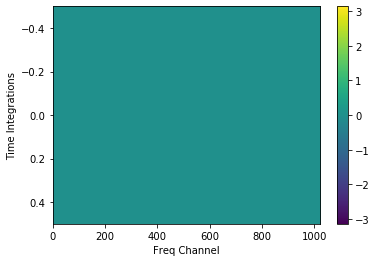

In [251]:
xkey = list(casagains.keys())

cc=casagains[(0, 'Jxx')]
#cc[xyflag_abs[(2, 'Jxx')]] *= np.nan #removing the bad data

#plt.imshow(np.abs(cc), aspect='auto', interpolation='nearest') #for Gain Amplitude
plt.imshow(np.angle(cc), aspect='auto', interpolation='nearest', vmin=-np.pi, vmax=np.pi) #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

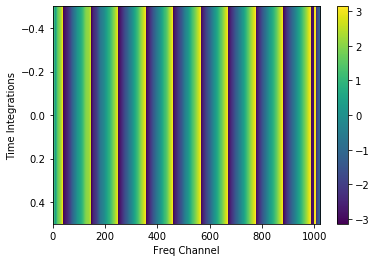

In [252]:
xkey = list(casagains.keys())

cc=casagains[(1, 'Jxx')]
#cc[xyflag_abs[(2, 'Jxx')]] *= np.nan #removing the bad data

#plt.imshow(np.abs(cc), aspect='auto', interpolation='nearest') #for Gain Amplitude
plt.imshow(np.angle(cc), aspect='auto', interpolation='nearest', vmin=-np.pi, vmax=np.pi) #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

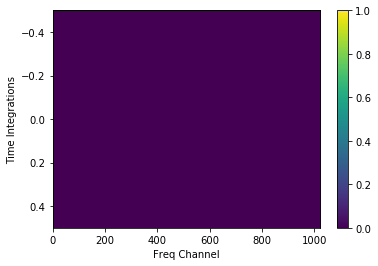

1024
0
1024
1024
0
0
1024
0
0
0
0
0
0
0
0
0
0
0
1024
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1024
0
0
0
0
0
0
0
0
0
0
0
0
0


In [288]:
plt.imshow(1*(casaflags[(1, 'Jxx')]), aspect='auto', interpolation='nearest', vmin=0,vmax=1) #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

for k in xkey[0::2]:
    print(np.sum(casaflags[k]))

# Redcal and Omnical Calibration

### Redcal

This flags the top and bottom 50 channels. solar_horizon=90 ensures that no integrations are flagged because the sun is up.

In [15]:
%%time
redcal.redcal_run(path+'uncalibrated_' + rimez_sim, 
                  flag_nchan_high=0, flag_nchan_low=0,
                  solar_horizon=90, clobber=True, verbose=True);


Now running redundant calibration without antennas [] ...
Now calibrating ['xx'] polarization(s)...
    Now calibrating times 2458106.2787823672 through 2458106.286114605 ...
Now calibrating ['yy'] polarization(s)...
    Now calibrating times 2458106.2787823672 through 2458106.286114605 ...
Throwing out antenna 98 for a z-score of 4.192563021906735 on polarization Jyy.

Throwing out antenna 136 for a z-score of 5.811373673836377 on polarization Jyy.

Throwing out antenna 137 for a z-score of 4.395941069411507 on polarization Jyy.

Throwing out antenna 136 for a z-score of 4.40582080733384 on polarization Jxx.


Now running redundant calibration without antennas [136, 137, 98] ...
Now calibrating ['xx'] polarization(s)...
    Now calibrating times 2458106.2787823672 through 2458106.286114605 ...


invalid value encountered in true_divide


Now calibrating ['yy'] polarization(s)...
    Now calibrating times 2458106.2787823672 through 2458106.286114605 ...


invalid value encountered in true_divide



Now saving firstcal gains to /Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.first.calfits
Now saving omnical gains to /Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.omni.calfits
Now saving omnical visibilities to /Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.omni_vis.uvh5


Telescope mock-HERA is not in known_telescopes.


CPU times: user 32min 44s, sys: 11min 40s, total: 44min 24s
Wall time: 46min 10s


{'g_firstcal': {(0,
   'Jyy'): array([[-0.9999692 -0.00784899j, -0.99985445-0.01705979j,
          -0.9996549 -0.02626914j, ...,  0.9999288 -0.01193623j,
           0.9999963 -0.00272496j,  0.99997896+0.00648654j],
         [-0.9999692 -0.00784899j, -0.99985445-0.01705979j,
          -0.9996549 -0.02626914j, ...,  0.9999288 -0.01193623j,
           0.9999963 -0.00272496j,  0.99997896+0.00648654j],
         [-0.9999692 -0.00784899j, -0.99985445-0.01705979j,
          -0.9996549 -0.02626914j, ...,  0.9999288 -0.01193623j,
           0.9999963 -0.00272496j,  0.99997896+0.00648654j],
         ...,
         [-0.9999692 -0.00784899j, -0.99985445-0.01705979j,
          -0.9996549 -0.02626914j, ...,  0.9999288 -0.01193623j,
           0.9999963 -0.00272496j,  0.99997896+0.00648654j],
         [-0.9999692 -0.00784899j, -0.99985445-0.01705979j,
          -0.9996549 -0.02626914j, ...,  0.9999288 -0.01193623j,
           0.9999963 -0.00272496j,  0.99997896+0.00648654j],
         [-0.9999692 -0.007

In [241]:
# Get Redcal flags from calfits file.
(rcgains, rcflags, rcquals, rctotal_qual,rcants, rcfreqs,
 rctimes, rcpols) = io.load_cal(path+"uncalibrated_zen.2458106.27878.omni.calfits", return_meta=True)

print(rcants.shape)
print(rcfreqs.shape)
print(rctimes.shape)
print(len(rcpols))

(104,)
(1024,)
(60,)
2


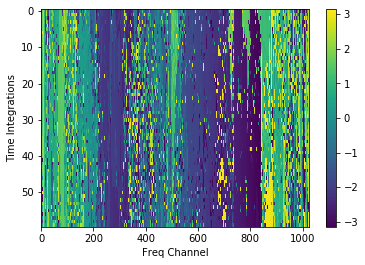

In [269]:
xkey = list(rcgains.keys())

cc=rcgains[(2, 'Jyy')]
#cc[xyflag_abs[(2, 'Jxx')]] *= np.nan #removing the bad data

#plt.imshow(np.abs(cc), aspect='auto', interpolation='nearest') #for Gain Amplitude
plt.imshow(np.angle(cc), aspect='auto', interpolation='nearest', vmin=-np.pi, vmax=np.pi) #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

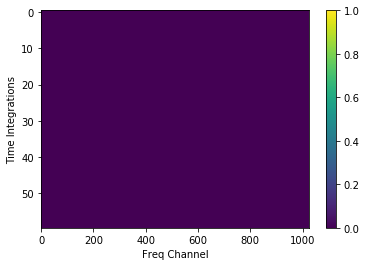

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
61440
0
0
0
0
0
61440
61440
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
61440
0
0
0
0
0
61440
61440
0
0
0
0
0
0


In [286]:
plt.imshow(1*(rcflags[(0, 'Jxx')]), aspect='auto', interpolation='nearest', vmin=0,vmax=1) #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

# Print Flags
for k in xkey[1::2]:
    print(np.sum(rcflags[k]))
    
print("\n")
    
for k in xkey[0::2]:
    print(np.sum(rcflags[k]))

# Abscal

The next thing to do is retreive the redcal data to start the post redcal abscal processing.

In [176]:
#SEEMS TO MAKE CALFITS FILE BUT ALL ANTS ARE FLAGGED

abscal.post_redcal_abscal_run(data_file = "/Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.uvh5", 
                       redcal_file = "/Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.omni.calfits", 
                       model_files = ["/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.28114.HH.uv.applyabscal.uvh5"], 
                       output_file = "/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.HH.uv.post_redcal_abscal_run.calfits", 
                       nInt_to_load=None, data_solar_horizon=90, model_solar_horizon=90, min_bl_cut=1.0, max_bl_cut=None, edge_cut=0, 
                           tol=1.0, phs_max_iter=100, phs_conv_crit=1e-6, refant=None, clobber=True, add_to_history='', verbose=True)

Telescope mock-HERA is not in known_telescopes.




Now calibrating xx-polarization...

    Now calibrating times 2458106.2787823672 through 2458106.286114605...


Now calibrating yy-polarization...

    Now calibrating times 2458106.2787823672 through 2458106.286114605...


Mean of empty slice.
invalid value encountered in double_scalars


In [162]:
# NOT WORKING
"""
abscal.post_redcal_abscal(model=casa_data, 
                   data=rc_data, # get from uvh5
                   flags=casa_flags, 
                   rc_flags=rc_flags,# get from uvh5
                   min_bl_cut=None, max_bl_cut=None, edge_cut=0, tol=1.0,
                   gain_convention='multiply', phs_max_iter=100, phs_conv_crit=1e-6,
                   refant_num=None, verbose=True)
"""

KeyError: (0, 1, 'xx')

In [245]:
# Examine the Calfits file.

calfits_file = "/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.HH.uv.post_redcal_abscal_run.calfits"

(abs_xygains, abs_xyflags, abs_xyquals, 
abs_xytotal_qual, abs_xyants, abs_xyfreqs, 
abs_xytimes, abs_xypols) = io.load_cal(calfits_file,return_meta=True)

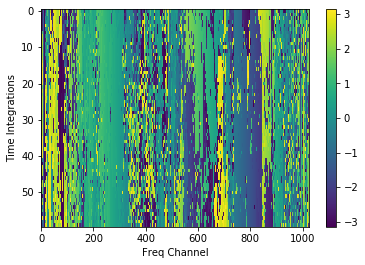

In [266]:
xkey = list(abs_xygains.keys())

cc=xygain_abs[(2, 'Jyy')]
#cc[xyflag_abs[(2, 'Jxx')]] *= np.nan #removing the bad data

#plt.imshow(np.abs(cc), aspect='auto', interpolation='nearest') #for Gain Amplitude
plt.imshow(np.angle(cc), aspect='auto', interpolation='nearest', vmin=-np.pi, vmax=np.pi) #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

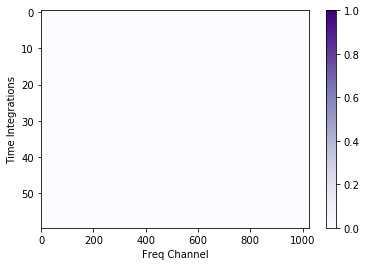

61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440


61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440
61440


In [281]:
plt.imshow(-1*(abs_xyflags[(2, 'Jxx')]), aspect='auto', 
           interpolation='nearest', vmin=0,vmax=1,cmap="Purples") #for Phase
plt.xlabel("Freq Channel")
plt.ylabel("Time Integrations")
plt.colorbar()
plt.show()

# Print Flags
for k in xkey[0::2]:
    print(np.sum(xyflag_abs[k]))

print("\n")
    
for k in xkey[0::2]:
    print(np.sum(xyflag_abs[k]))

In [27]:
# Get Redcal data from uvh5 file.
rc_data, rc_flags, rc_nsamples = io.HERAData(path+"uncalibrated_zen.2458106.27878.omni_vis.uvh5").read()

#### Apply CASA solutions to uncalibrated data file.


In [178]:
%%bash

apply_cal.py --new_cal=/Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.HH.uv.post_redcal_abscal_run.calfits --filetype_in uvh5 --filetype_out uvh5 /Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.uvh5 /Users/tashaleebillings/Desktop/data/2.2Validation/zen.2458106.27878.HH.post_redcal_abscal_run.uvh5


Telescope mock-HERA is not in known_telescopes.
Telescope mock-HERA is not in known_telescopes.


# Calibrated Visibility Comparison